<h2><center>Valorisations des données piscicoles diffusées par Hub'Eau</center></h2>

Auteur : Benoit Lefeuvre

Chef de projet : Eddy Cosson

Dernière mise à jour : 22/01/2024

<hr style="border-width: 2px ; border-color: #ADD8E6">

Hub’Eau est la plateforme nationale des API du Système d’Information sur l’Eau (SIE). Elle met à disposition 12 API diffusant plus de 630 millions d’observations et de mesures issues de 9 banques de données nationales. Les données piscicoles sont diffusées par deux API, l'API Poisson et l'API Hydrobiologie.

L’[API Hub'Eau Poisson](https://hubeau.eaufrance.fr/page/api-poisson) expose le périmètre le plus large de données : observations à l’échelle de l’individu réalisée sur une station possiblement non référencée par le Sandre. De son côté, l’[API Hub'Eau Hydrobiologie](https://hubeau.eaufrance.fr/page/api-hydrobiologie) diffuse des données agrégées à l’échelle du taxon collectées sur des stations référencées par le Sandre.

Ce notebook illustre les possibilités de valorisation des données piscicoles permises par ces deux API sur la base de cas simples.

<hr style="border-width: 2px ; border-color: #ADD8E6">

## 1 - PREAMBULE

## 1.1- Prérequis
L'exécution du code Python requiert l'installation de tierces librairies. Le code a été testé avec succès avec la configuration suivante :

version conda : conda 23.11.0
- Python : 3.10.13
    - altair : 5.2.0
    - contextily : 1.5.0
    - geopandas : 0.14.3
    - matplotlib : 3.7.2
    - matplotlib_venn : 0.11.10
    - numpy : 1.26.3
    - pandas : 2.2.0
    - requests : 2.31.0
    - seaborn : 0.13.2

<hr style="border-width: 2px ; border-color: #ADD8E6">

## 1.2- Chargement des modules

In [230]:
import json
import os
import re
import sys
import time
from functools import wraps
import warnings

import altair as alt
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import requests
import seaborn as sns

warnings.filterwarnings('ignore')

Url simple sans filtre sur la table opérations (endpoint)  

In [231]:
api_url = "https://hubeau.eaufrance.fr/api/v1/etat_piscicole/operations"

On récupére la donnée avec `requests` dans une variable `response` :

In [232]:
response = requests.get(api_url)

On récupère les données json dasn un dictionnaire Python :

In [233]:
data = response.json()
print("type de la variable ", type(data))

type de la variable  <class 'dict'>


`data` est un dictionnaire sur lequel on peut obtenir le nombre total de données renvoyé par l'url, le nombre de pages, la première et la dernière url d'accès à la totalité de la requête :

In [234]:
print("Le nombre de donnée de la table opération est de ", data['count'], ". \n")
print("L'url d'accés à la première page de données ", data['first'], ". \n")
print("L'url d'accés à la dernière page de données ", data['last'], ". \n")

Le nombre de donnée de la table opération est de  52111 . 

L'url d'accés à la première page de données  https://hubeau.eaufrance.fr/api/v1/etat_piscicole/operations?page=1&size=5000 . 

L'url d'accés à la dernière page de données  https://hubeau.eaufrance.fr/api/v1/etat_piscicole/operations?page=11&size=5000 . 



Les attributs `prev` et `next` (renseignés à `null` si il n'y a pas de page précédente et/ou suivante) sont disponibles dans l'URL de la réponse pour éviter d'avoir à calculer les pages précédentes et/ou suivantes

- L'attribut `first` permet d'accéder à la première page des résultats,
- L'attribut `last` permet d'accéder à la dernière page des résultats,
- L'attribut `count` permet de compter le nombre total de résultats,
- L'attribut `data` permet d'accéder à une page de résultats sous forme de liste.

<hr style="border-width: 2px ; border-color: #ADD8E6">

## 1.3- Classe d'interfaçage avec l'API Hub'Eau Poisson

Afin de faciliter l'utilisation de l'API , nous allons définir et utiliser une classe Python `APIPoisson` dont les méthodes permettent l'appel des url des différents endpoint de l'API Poisson. Le code fournit des exemples d'utilisation de la classe.

In [235]:
class APIPoisson:
    from functools import wraps
    """ Classe permettant de requêter les 4 endpoint avec la variable correspondante :
        - operation (ENDPOINT_OPERATION)
        - indicateurs (ENDPOINT_INDICATEURS)
        - observations (ENDPOINT_OBSERVATIONS)
        - stations (ENDPOINT_STATIONS)
    - version V1 https://hubeau.eaufrance.fr/page/api-poisson#/Etat_piscicole"""
    
    #BASE_URL = "https://hubeau.eaufrance.fr/api"
    ENDPOINT_OPERATION = "v1/etat_piscicole/operations"
    ENDPOINT_INDICATEURS = "v1/etat_piscicole/indicateurs"
    ENDPOINT_OBSERVATIONS = "v1/etat_piscicole/observations"
    ENDPOINT_STATIONS = "v1/etat_piscicole/stations"
    ENPOINT_HYDROLOGIE="/v1/hydrobio/indices"
    
    def __init__(self, base_url):
        self.base_url = base_url
        
    def assertJsonSuccess(self, data):
        """test de connexion"""
        df = data.text
        obj = json.loads(df)
        if 'status' in obj and obj['status'] == "error":
            print("Error: le fichier json retourne une erreur....probleme de certificat ou de parametre de connexion " + str(obj))
            sys.exit(1)
            return False
        else:
            return True
        
    def timing(func):
        """Mesure le temps d'exécution de la fonction passée e paramètre"""
        @wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()
            print("Durée d'exécution : {:1.3}s \n".format(end_time - start_time))
            return result

        return wrapper
    
    def lecture_page(self, data):
        """Renvoi la page de l url"""
        try:
            url = data
            match = re.search(r'page=(\d+)', url)
            return match.group(1)
        except (TypeError, ValueError) as e:
            print(e)
            return None
    
    def lecture_nbre_donnee(self, data):
        """Renvoi le nombre de données de la requête url"""
        url = data['first']
        match = re.search(r'size=(\d+)', url)
        return match.group(1)
    
    @timing
    def get_data(self, endpoint, requ):
        """Interroge l'url et obtient la donnée et les références"""
        
        if requ:
            url = f"{self.base_url}/{endpoint}?{requ}"
        else:
            url = f"{self.base_url}/{endpoint}"
            
        try:

            with requests.get(url) as response:
                if self.assertJsonSuccess(response):
                    if response.status_code == 206:
                        data = response.json()
                        total = data['count']

                        if data['prev']:
                            actuelle_page = int(self.lecture_page(data['prev']))+1
                        else:
                            actuelle_page = self.lecture_page(data['first'])
                        if data['last']:
                            nbre_page = self.lecture_page(data['last'])
                        else:
                            nbre_page = int(actuelle_page)

                        nbre_ope = self.lecture_nbre_donnee(data)
                        print(url)
                        print(f'La réponse est partielle et contient {nbre_ope} données (le maximum par page) sur {total}. Page chargé n° {actuelle_page} sur {nbre_page} page ')
                        return pd.DataFrame(data['data'])

                    elif response.status_code == 200:
                        data = response.json()
                        total = data['count']
                        print(url)
                        print(f'La réponse est complète et contient {total} données')
                        return pd.DataFrame(data['data'])

                    else:
                        print('Erreur interne ou non autorisé du serveur', {response.status_code})

                else:
                    print(f'erreur lors de la lecture de l adresse.')

                
        except requests.RequestException as e:
            raise ValueError(f"Erreur: Une erreur lors de la requête - {e}")

    def get_operation(self, requ=None):
        """Renvoi les opérations""" #EC
        try:
            return self.get_data(self.ENDPOINT_OPERATION, requ)
        except ValueError as e:
            print(e)
            return None

    def get_indicateurs(self, requ=None):
        """Renvoi les indicateurs""" 
        try:
            return self.get_data(self.ENDPOINT_INDICATEURS, requ)
        except ValueError as e:
            print(e)
            return None

    def get_observations(self, requ=None):
        """Renvoi les observations"""
        try:
            return self.get_data(self.ENDPOINT_OBSERVATIONS, requ)
        except ValueError as e:
            print(e)
            return None

    def get_stations(self, requ=None):
        """Renvoi les stations"""
        try:
            return self.get_data(self.ENDPOINT_STATIONS, requ)
        except ValueError as e:
            print(e)
            return None
        
    def get_all_data(self, endpoint, requ=None):
        """Renvoi un dataframe contenant les differentes pages d'un appel url"""
        page = 1
        all_data = pd.DataFrame()
        print("Assemblage des pages....")
        while True:
            #requête avec le numéro de page
            current_requ = f"{requ}&page={page}&size=5000" if requ else f"page={page}&size=5000"

            #données de la page actuelle
            page_data = self.get_data(endpoint, current_requ)
            # Arrêt la boucle si aucune donnée n'est renvoyée
            if page_data is None:
                print(f"Aucune donnée n'a été renvoyée pour la requête : {current_requ}")
                break
            if page_data.empty:
                break

            # Ajout les données de la page actuelle au DataFrame global
            all_data = pd.concat([all_data, page_data], ignore_index=True)

            #page suivante
            page += 1
        
        return all_data

On peut lancer des requêtes sans filtrer afin d'obtenir la première page et le nombre de données sur chaque Endpoint :

In [236]:
base_url = "https://hubeau.eaufrance.fr/api"
api_lecture = APIPoisson(base_url)
# Récupérer les données pour chaque endpoint
df_operation = api_lecture.get_operation()
df_indicateurs = api_lecture.get_indicateurs()
df_observations = api_lecture.get_observations()
df_stations = api_lecture.get_stations()

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/operations
La réponse est partielle et contient 5000 données (le maximum par page) sur  52111. Page chargé n° 1 sur 11 page 
Durée d'exécution : 4.33s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/indicateurs
La réponse est partielle et contient 5000 données (le maximum par page) sur  32531. Page chargé n° 1 sur 7 page 
Durée d'exécution : 7.33s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/observations
La réponse est partielle et contient 5000 données (le maximum par page) sur  9460724. Page chargé n° 1 sur 1893 page 
Durée d'exécution : 4.93s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/stations
La réponse est partielle et contient 5000 données (le maximum par page) sur  15060. Page chargé n° 1 sur 4 page 
Durée d'exécution : 2.8s 



L'accés aux données s'effectue par page de 5000 résultats maximum. Le nombre maximum de résultats d'une recherche est fixé à 20 000.

L'API n'est évidemment pas adaptée au chargement complet de la donnée d'observation (9 millions de données, soit 1850 pages.

Néanmoins, un datapaper et des données complètes datées de juin 2023 sont disponibles :

- Datapaper : https://www.kmae-journal.org/articles/kmae/full_html/2022/01/kmae220057/kmae220057.html
  
- BDD : https://zenodo.org/records/8099409

<hr style="border-width: 2px ; border-color: #ADD8E6">

La méthode `get_all_data` de la classe `APIPoisson` permet l'assemblage de plusieurs pages dans un dataframe complet.
Cette fonction utilise une des 4 variables endpoint afin de choisir le type de donnée :

        - operation (ENDPOINT_OPERATION)
        - indicateurs (ENDPOINT_INDICATEURS)
        - observations (ENDPOINT_OBSERVATIONS)
        - stations (ENDPOINT_STATIONS)


On peut récupérer par exemple la totalité des opérations dont le nombre de lignes reste accessible.

In [237]:
base_url = "https://hubeau.eaufrance.fr/api"
api_lecture = APIPoisson(base_url)

# df_all_data contient toutes les opérations
df_all_data = api_lecture.get_all_data(api_lecture.ENDPOINT_OPERATION)

Assemblage des pages....
https://hubeau.eaufrance.fr/api/v1/etat_piscicole/operations?page=1&size=5000
La réponse est partielle et contient 5000 données (le maximum par page) sur  52111. Page chargé n° 1 sur 11 page 
Durée d'exécution : 5.2s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/operations?page=2&size=5000
La réponse est partielle et contient 5000 données (le maximum par page) sur  52111. Page chargé n° 2 sur 11 page 
Durée d'exécution : 4.86s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/operations?page=3&size=5000
La réponse est partielle et contient 5000 données (le maximum par page) sur  52111. Page chargé n° 3 sur 11 page 
Durée d'exécution : 7.16s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/operations?page=4&size=5000
La réponse est partielle et contient 5000 données (le maximum par page) sur  52111. Page chargé n° 4 sur 11 page 
Durée d'exécution : 5.59s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/operations?page=5&size=5000
La réponse est par

<hr style="border-width: 2px ; border-color: #ADD8E6">

## 2 - Exploitation des données de l'API Poisson

Sur la base des endpoint station et opération il est possible de réaliser diverses analyses à différentes échelles spatiales ou temporel.

### 2.1- Profondeur de chroniques des stations SANDRE de la région Normandie

Nous allons maintenant nous intéresser au nombre d'opérations réalisées sur les différentes stations de suivi de la région Normandie :

In [238]:
#on crée une colonne année à partir du champ date_operation (format YYYY-MM-DDThh:mm:ssZ)
df_all_data = df_all_data.assign(annee=df_all_data['date_operation'].str.slice(0,4))
#filtre sur la region
df_all_data_normandie = df_all_data.query("libelle_region == 'NORMANDIE'")
# on crée un dataframe avec des données uniques
df_all_data_annee = df_all_data_normandie[['code_station', 'annee']].drop_duplicates()

Certaines stations peuvent ne pas avoir de code station sandre. Dans ce cas, elles sont un un code point de prélèvement ASPE. Il est alors nécessaire de se référer aux colonnes suivantes : `code_point_prelevement,code_point_prelevement_aspe`

In [239]:
# on enleve les valeurs null (stations Wama)
df_all_data_annee = df_all_data_annee.dropna()

On agrége les années dans une colonne et sur une seule ligne pour chaque stations :

In [240]:
df_all_data_anneegraphe = df_all_data_annee.groupby(['code_station']).aggregate(lambda x: list(x)).reset_index()
#on compte le nombre d'annéees de présence de la station
df_all_data_anneegraphe['nbre'] = df_all_data_anneegraphe['annee'].apply(lambda x: len(x))

On récupère l'emprise temporelle de la donnée :

In [241]:
df_all_data_annee_max, df_all_data_annee_min = df_all_data_annee['annee'].max(), df_all_data_annee['annee'].min()

In [242]:
def graphe_comparaison_annee(data, annemax, annemin):
    '''
    data :: dataframe avec la colonne nombre d'année
    annemax :: maximum de la colonne date 
    annemin :: minimum de la colonne date 
    '''

    #figure et axes
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = plt.axes([1, 0.1, 0.2, 0.8])

    #graphe
    sns.set_theme(style="whitegrid")
    sns.countplot(y=data, palette="flare", ax=ax1)
    
    titre = "Profondeur de chroniques de suivi des stations entre " + annemin + " et " + annemax
    ax1.set_title(titre, pad=20)
    ax1.set_xlabel("Nombre de stations", labelpad=30)

    ax1.set_ylabel("Profondeur des chroniques en années", labelpad=30)
    
    #Table
    table_data = data.value_counts().reset_index()
    table_data.columns = ['Nombre d\'année où la station \n est présente', 'Nombre de stations']
    table = ax2.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])

    #hauteur et largeur de la table
    hauteur = 0.035
    largeur = 0.7
    for cell in table._cells.values():
        cell.set_height(hauteur),cell.set_width(largeur)

    table.auto_set_font_size(False)
    table.set_fontsize(10)

    plt.show()

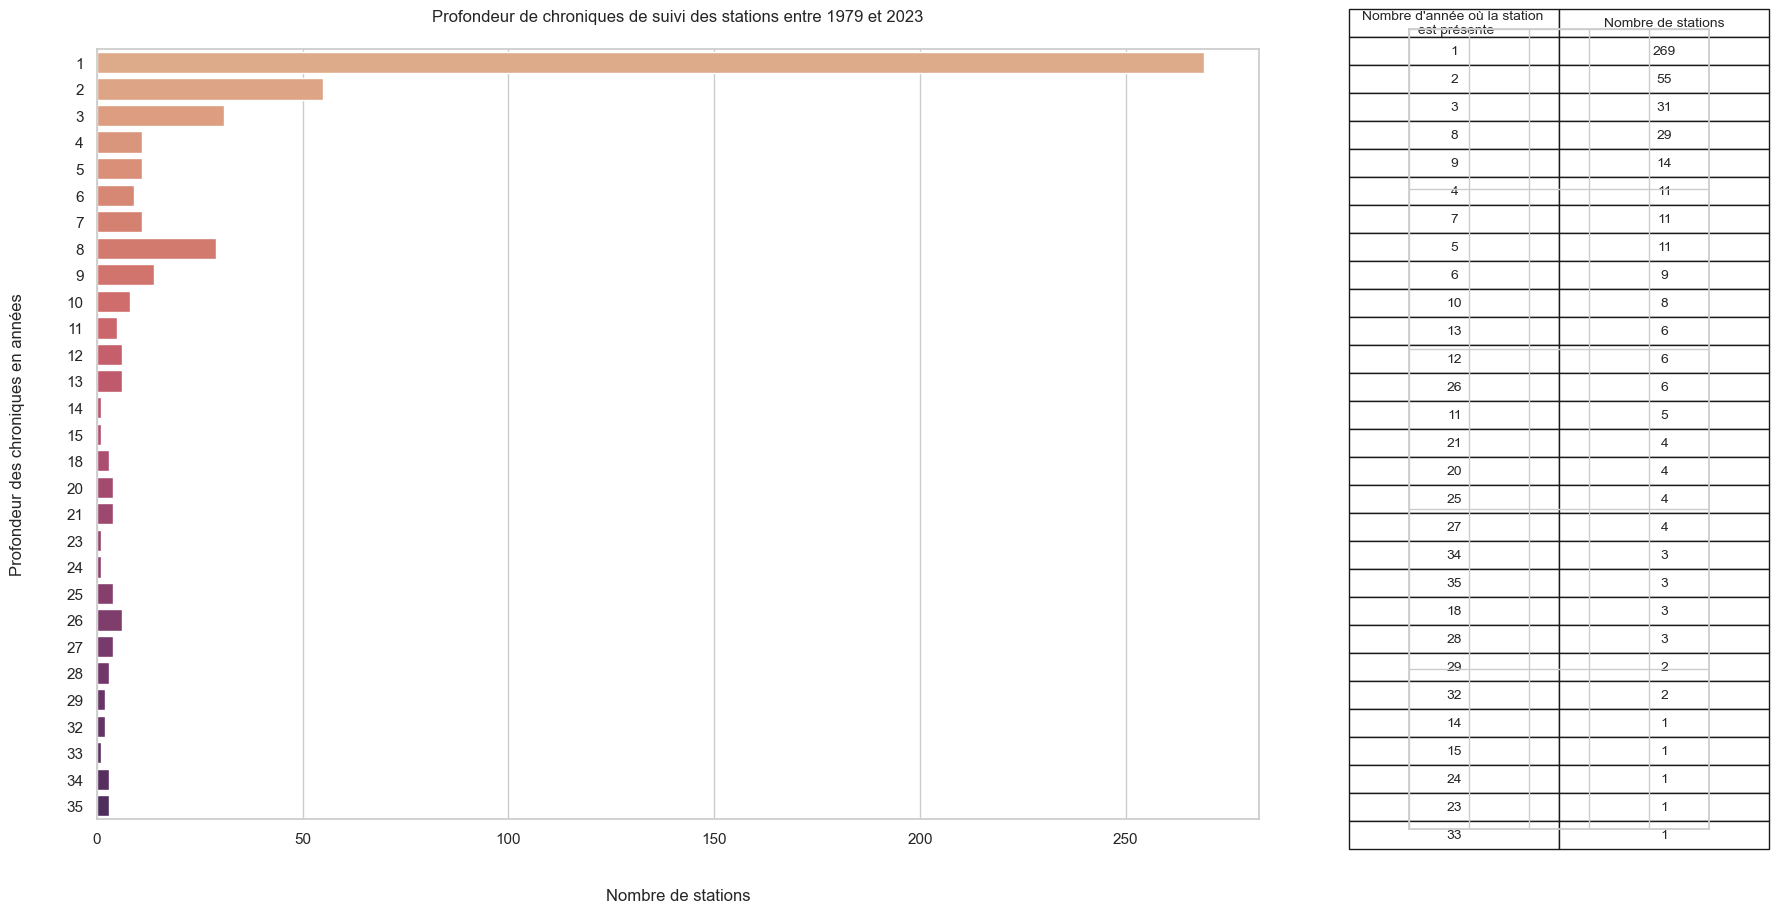

In [243]:
graphe_comparaison_annee(df_all_data_anneegraphe['nbre'], df_all_data_annee_max, df_all_data_annee_min)

<hr style="border-width: 2px ; border-color: #ADD8E6">

### 2.2- Evaluation de la récurrence d’échantillonnage des stations SANDRE normandes entre 2020 et 2022

Nous allons continuer l'exploration des données sur plusieurs stations en s'interessant à leur fréquence d'échantillonnage. L'objectif sera ici de connaitre la représentativité de la fréquence d'échantillonnage des stations sur la période 2020-2022. 

In [244]:
def construction_venn(titre, data, stations):
    '''titre::format text pour le titre du graphe
    data :: dataframme avec les colonne stations et année
    stations : str nom de la colonne station'''

    Annee_2020_ = data.query("annee == '2020'")[stations]
    Annee_2021_ = data.query("annee== '2021'")[stations]
    Annee_2022_ = data.query("annee == '2022'")[stations]

    Annee_2020 = set(Annee_2020_)
    Annee_2021 = set(Annee_2021_)
    Annee_2022 = set(Annee_2022_)

    plt.figure(figsize=(10,10))

    v = venn3([Annee_2020,Annee_2021,Annee_2022],('Année 2020','Année 2021','Année 2022'),set_colors=('#1ac0c6','#fb7756','#8936b3'))
    c = venn3_circles(subsets = (Annee_2020,Annee_2021,Annee_2022), linestyle='dashed', linewidth=1, color="grey")
    titregraphe = titre + " : Récurrence d’échantillonnages des stations SANDRE normandes entre 2020 et 2022"
    plt.title(titregraphe, pad=20)
    plt.annotate('Nombre de stations présentes \n sur les 3 annéees', xy=v.get_label_by_id('111').get_position()-np.array([0, 0.08]), xytext=(-50,-70)
                 ,ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.8', fc='gray', alpha=0.1),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
    plt.show()
    return 

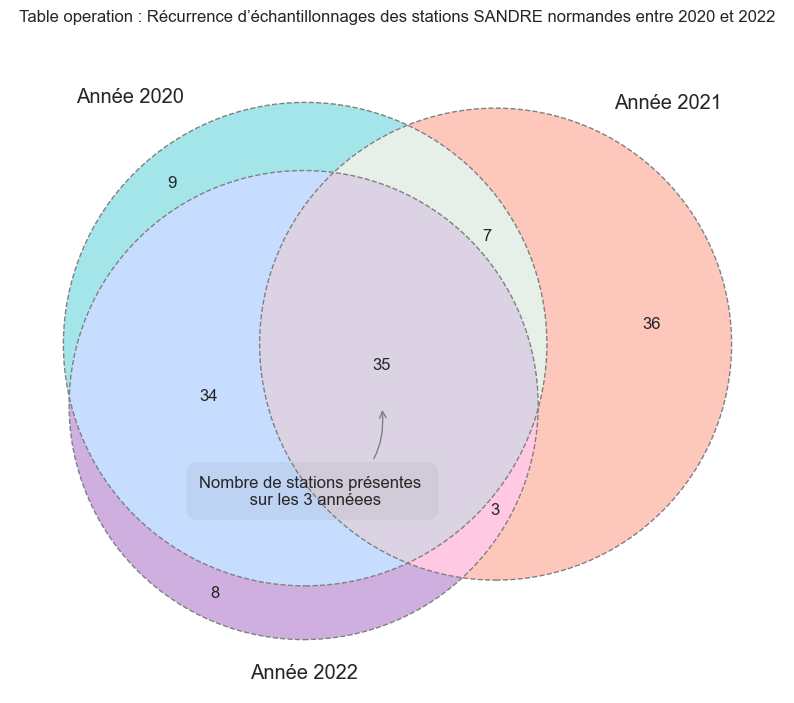

In [245]:
construction_venn("Table operation", df_all_data_annee, 'code_station')

<hr style="border-width: 2px ; border-color: #ADD8E6">

### 2.3- Cartographie des stations SANDRE et de leur profondeur de chronique 

On peut représenter le nombre d'opération par station :

In [246]:
df_all_data_stations=df_all_data.groupby(['code_station','coordonnee_x_station', 'coordonnee_y_station',]).agg(nbre=('code_operation','count')).reset_index()

On crée un dataframe spatial en utilisant la librairie `Geopandas`:

In [247]:
geometry = gpd.points_from_xy(df_all_data_stations["coordonnee_x_station"], df_all_data_stations["coordonnee_y_station"])

geo_df_all_data_stations = gpd.GeoDataFrame(
    df_all_data_stations, crs="EPSG:2154", geometry=geometry
)

Emprise de la donnée :

In [248]:
ouest, sud, est, nord = (-2129926, 4479313, 3560484, 7387511)
box_map = geo_df_all_data_stations.cx[ouest:est, nord:sud]

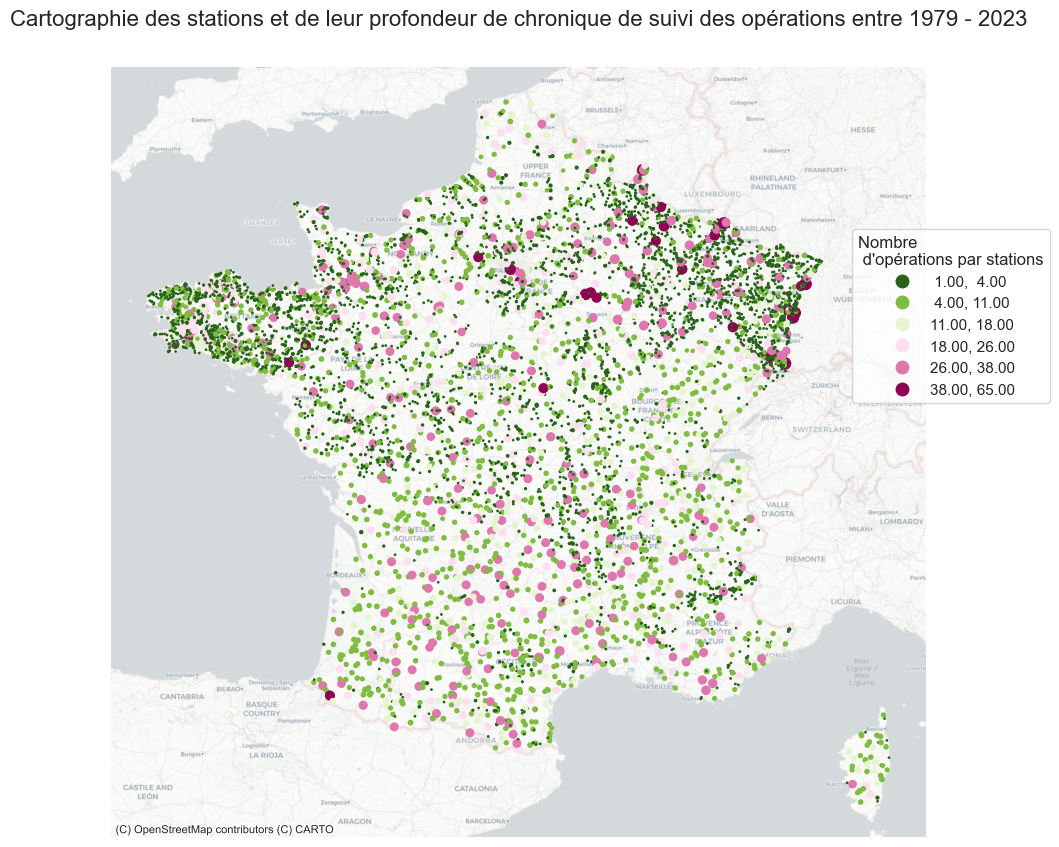

In [249]:
import contextily as ctx

ax = box_map.to_crs('EPSG:3857').plot(
    figsize=(18,10), markersize="nbre", alpha=1, column="nbre", k=6, cmap='PiYG_r', scheme='natural_breaks', categorical=False,
    legend=True, legend_kwds={'bbox_to_anchor': (0.9, 0.8)})
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
#on enleve les axes
ax.axis("off")
#emprise temporelle
max = df_all_data_annee_max
min = df_all_data_annee_min

plt.title("Cartographie des stations et de leur profondeur de chronique de suivi des opérations entre "+str(min)+" - "+str(max), pad=30, fontsize=16)
leg = ax.get_legend()
leg.set_title("Nombre \n d'opérations par stations")

plt.show()

<hr style="border-width: 2px ; border-color: #ADD8E6">

### 2.4- Station avec le plus d'opération et descriptifs sur les observations

On détermine la station avec le plus d'opérations sur l'emprise temporelle du ENDPOINT (opération) :

In [250]:
df_all_data_anneegraphe = df_all_data_anneegraphe.sort_values('nbre', ascending=False)

In [251]:
df_all_data_anneegraphe.nlargest(3,'nbre')

code_station                                              annee  nbre
345     03248401  [2023, 2022, 2021, 2020, 2019, 2018, 2017, 201...    35
385     03257800  [2023, 2022, 2021, 2020, 2019, 2018, 2017, 201...    35
221     03227475  [2023, 2022, 2021, 2020, 2019, 2018, 2017, 201...    35

In [252]:
print(f"Le code_station {list(df_all_data_anneegraphe.code_station)[1]} a été utilisé {list(df_all_data_anneegraphe.nbre)[0]} "
      + f"fois sur les années : {list(df_all_data_anneegraphe.annee)[1]} ")

Le code_station 03257800 a été utilisé 35 fois sur les années : ['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990', '1989'] 


On peut maintenant utiliser la classe APIPoisson pour obtenir les observations liées à cette station :

In [253]:
requ = f'code_station={list(df_all_data_anneegraphe.code_station)[1]}'

In [254]:
df_observations = api_lecture.get_observations(requ)

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/observations?code_station=03257800
La réponse est partielle et contient 5000 données (le maximum par page) sur  12757. Page chargé n° 1 sur 3 page 
Durée d'exécution : 4.93s 



La réponse contient plusieurs pages.

On peut utiliser la méthode `get_all_data` de la classe APIPoisson pour assembler les pages des observations liées à cette station :

In [255]:
requ = f'code_station={list(df_all_data_anneegraphe.code_station)[1]}'
df_all_data_obs = api_lecture.get_all_data(api_lecture.ENDPOINT_OBSERVATIONS, requ)

Assemblage des pages....
https://hubeau.eaufrance.fr/api/v1/etat_piscicole/observations?code_station=03257800&page=1&size=5000
La réponse est partielle et contient 5000 données (le maximum par page) sur  12757. Page chargé n° 1 sur 3 page 
Durée d'exécution : 3.24s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/observations?code_station=03257800&page=2&size=5000
La réponse est partielle et contient 5000 données (le maximum par page) sur  12757. Page chargé n° 2 sur 3 page 
Durée d'exécution : 3.31s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/observations?code_station=03257800&page=3&size=5000
La réponse est partielle et contient 5000 données (le maximum par page) sur  12757. Page chargé n° 3 sur 3 page 
Durée d'exécution : 2.34s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/observations?code_station=03257800&page=4&size=5000
La réponse est complète et contient 12757 données
Durée d'exécution : 1.07s 



On ajoute l'année dans une colonne à partir du champ `date_operation` :

In [256]:
df_all_data_obs = df_all_data_obs.assign(annee=df_all_data_obs['date_operation'].str.slice(0,4))

In [257]:
print(f'La stations se situe sur le bassin {df_all_data_obs.libelle_bassin.unique()[0]} dans la commune {df_all_data_obs.libelle_commune.unique()[0]}')

La stations se situe sur le bassin SEINE-NORMANDIE dans la commune BRILLEVAST


On utilise la librairie `Altair` afin d'avoir un graphique dynamique représentant l'occurrence de chaque espèces sur la stations :

In [258]:
df_all_data_obs_par_annee = df_all_data_obs.groupby(['code_alternatif_taxon','annee']).size().reset_index(name='nbre')

In [259]:
titre = f"Occurence de poissons par année sur la stations : {list(df_all_data_obs.code_station.unique())[0]}"

In [260]:
alt.Chart(df_all_data_obs_par_annee,title=alt.TitleParams(text=titre,
                                    dy=-15)).mark_rect().encode(
    x='annee:O',
    y='code_alternatif_taxon:O',
    color=alt.Color(
        'nbre:Q', scale=alt.Scale(scheme='yellowgreenblue', domain=(1,220))),
    tooltip=[
        alt.Tooltip('annee:O', title='Année'),
        alt.Tooltip('nbre:O', title='Nombre occurence')
    ]).properties(width=700, height=400)

alt.Chart(...)

<hr style="border-width: 2px ; border-color: #ADD8E6">

### 2.5- Relation taille / poids par espèce sur la station comportant le plus d'opérations


In [261]:
data_poids_taille = df_all_data_obs[['code_alternatif_taxon', 'taille_individu','poids_individu_mesure']]

data_poids_taille = data_poids_taille.dropna()

On enlève les poids_individu_mesure égale à 0.0 :

In [262]:
data_poids_taille_sans_zero = data_poids_taille.query('poids_individu_mesure != 0.0')

<Figure size 1000x1000 with 0 Axes>

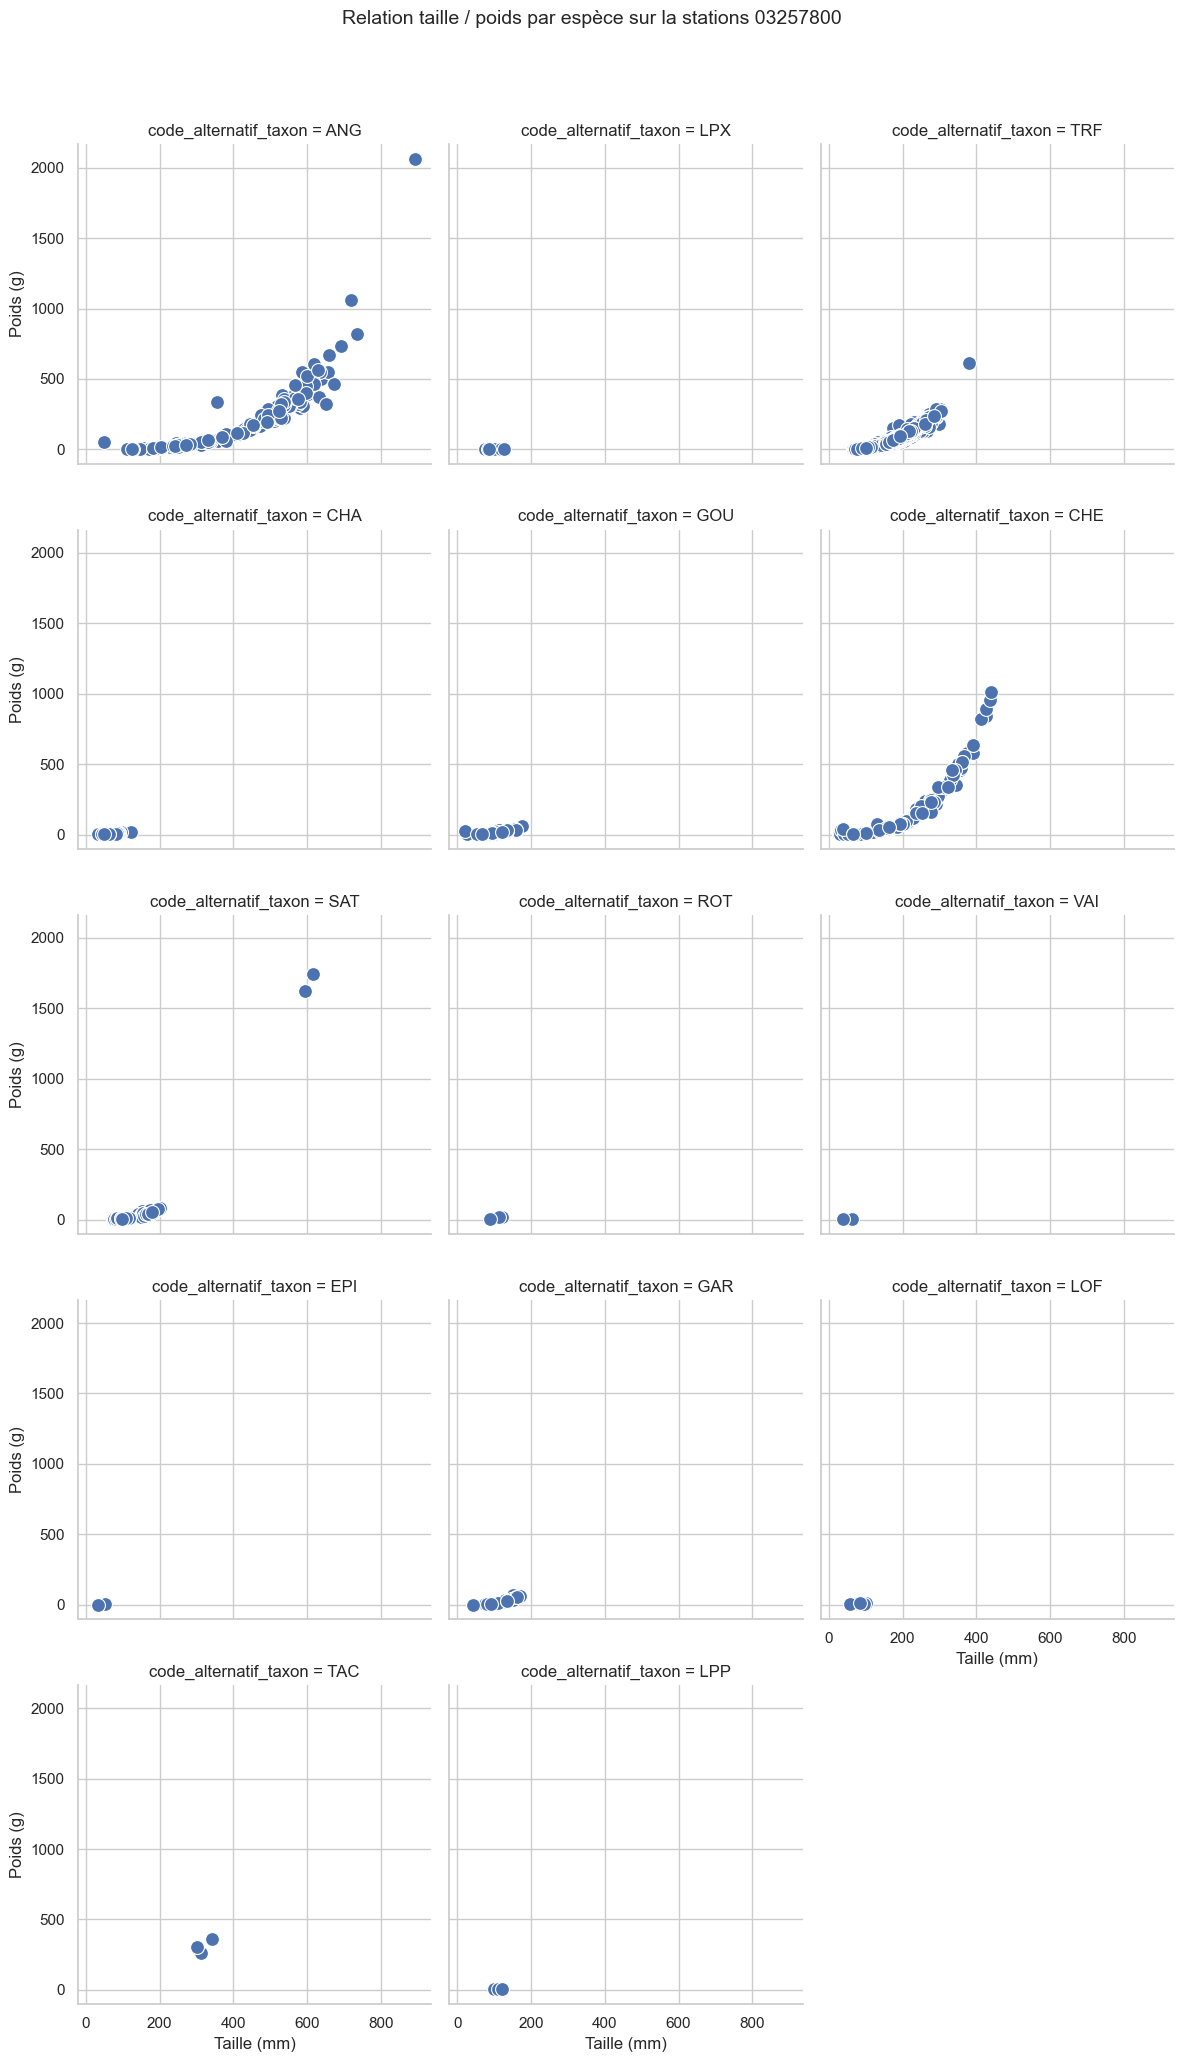

In [263]:
plt.figure(figsize=(10,10))

#figure sur 3 colonnes et 4 lignes
g = sns.FacetGrid(data_poids_taille_sans_zero, col='code_alternatif_taxon', col_wrap=3, height=4)
g.map(sns.scatterplot, 'taille_individu', 'poids_individu_mesure', s=100)

g.set_axis_labels("Taille (mm)","Poids (g)")
g.fig.suptitle(f"Relation taille / poids par espèce sur la stations {list(df_all_data_obs.code_station.unique())[0]}",
         y=1.03,fontsize=14)

plt.tight_layout()
plt.show()

<hr style="border-width: 2px ; border-color: #ADD8E6">

### 2.6- Etude à l'échelle de l'opération

#### 2.6.1 - Calcul des effectifs par taxon

Sur la base des résultats précédents,  les effectifs par taxon observé pendant cette opération peuvent être calculés et représentés graphiquement. 

In [264]:
requ = "code_operation=89237"
# Récupérer les données pour chaque endpoint à l'aide d'une requête
df_observations = api_lecture.get_observations(requ)

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/observations?code_operation=89237
La réponse est complète et contient 85 données
Durée d'exécution : 1.09s 



In [265]:
print(f'Le dataframe contient {df_observations.shape[0]} données et {df_observations.shape[1]} colonnes')

Le dataframe contient 85 données et 114 colonnes


<hr style="border-width: 2px ; border-color: #ADD8E6">

A l'aide de cette requête , on peut déterminer les effectifs observés pendant cette opération

In [266]:
df_effectif = df_observations.groupby(['nom_commun_taxon']).size().reset_index(name='nbre')
df_effectif =df_effectif.sort_values('nbre')

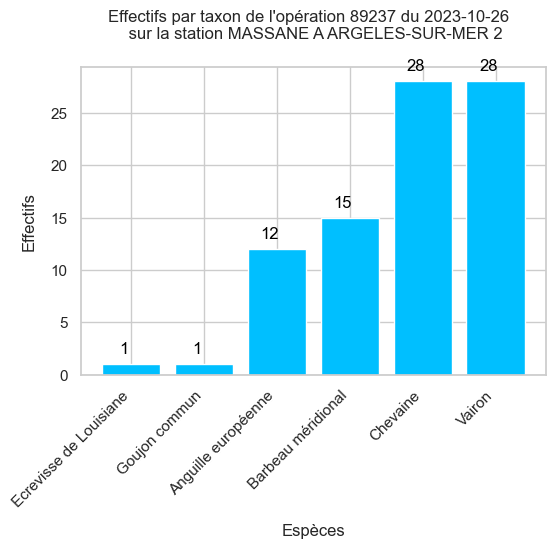

In [267]:

plt.figure(figsize=(6,4))
#une couleur par barre
axe = plt.bar(df_effectif.nom_commun_taxon, df_effectif.nbre, color='deepskyblue')

plt.xlabel('Espèces',labelpad=10)
plt.ylabel('Effectifs',labelpad=10)

plt.title(f"Effectifs par taxon de l'opération {requ[15:]} du {list(df_operation.date_operation)[0][0:10]}  \n sur la station {list(df_observations.libelle_station.unique())[0]}",pad=20)
plt.xticks(rotation=45, ha="right")

for ax, valeur in zip(axe, df_effectif.nbre):
    plt.text(ax.get_x() + ax.get_width() / 2 - 0.1, ax.get_height() +1, str(valeur), ha='center', color='black')
    
plt.show(block=False)

#### 2.3.2 - Effectif par classe de taille 


On peut par la suite afficher l'effectif du vairon par classe de taille de 2mm

In [268]:
df_effectif_taille = df_observations.groupby(['nom_commun_taxon','taille_individu']).agg(nbre=('effectif_lot', 'sum')).sort_values('nbre').reset_index()


In [269]:
df_effectif_taille_vairon=df_effectif_taille.query("nom_commun_taxon == 'Vairon'")

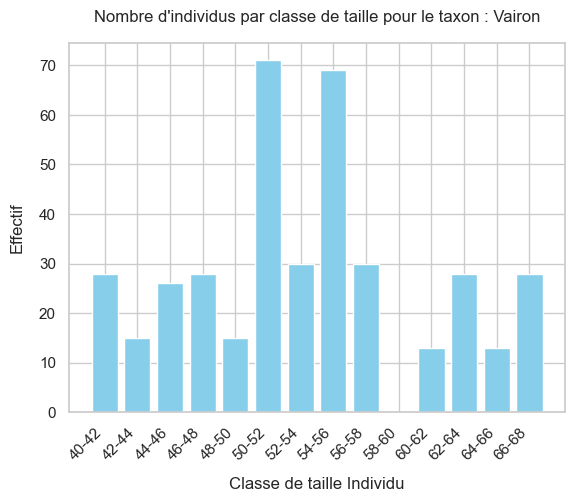

In [270]:
import matplotlib.pyplot as plt

#intervalles
taille_min = df_effectif_taille_vairon['taille_individu'].min()
taille_max = df_effectif_taille_vairon['taille_individu'].max()
#par classe de 2mm
nb_intervalles = (taille_max - taille_min) // 2 + 1
#intervalle basse>> on predn taille min + index boucle *par 2mn (tranche de classe)
#intervale haute >> on prend taille min+ on passe a l index suivant'+1) * par 2mm
intervalle_taille = [(taille_min + i * 2, taille_min + (i + 1) * 2) for i in range(nb_intervalles)]

#liste pour enregistrer le nbre par classe de taille
taille_individu_regroupee = []
nbre_regroupe = []

#on regroupe les données par classe de taille en boucle
for intervalle in intervalle_taille:
    #on prend les intervalles de chaque classe
    taille_min, taille_max = intervalle
    #on denombre par classe
    total_nbre = df_effectif_taille_vairon[(df_effectif_taille_vairon['taille_individu'] >= taille_min) & 
                                            (df_effectif_taille_vairon['taille_individu'] < taille_max)]['nbre'].sum()
    #on ajoute par classes
    taille_individu_regroupee.append(f"{taille_min}-{taille_max}")
    #on ajoute a la liste le denombre par classe
    nbre_regroupe.append(total_nbre)

plt.bar(taille_individu_regroupee, nbre_regroupe, color='skyblue')

#étiquettes
plt.xlabel('Classe de taille Individu',labelpad=10)
plt.ylabel('Effectif',labelpad=10)
plt.title('Nombre d\'individus par classe de taille pour le taxon : Vairon',pad=15)
plt.xticks(rotation=45, ha='right')
#ajout grille
plt.grid(True)

plt.show()


<hr style="border-width: 2px ; border-color: #ADD8E6">

### 2.7- Evolution de la note de l'IPR

Pour information, l'IPR (Indice poisson rivière) est un indicateur employé pour évaluer la qualité des peuplements piscicoles. Il est notamment employée dans l'évaluation de l'EQB poisson au titre de la directive cadre sur l'eau (DCE). Il consiste à mesurer l'écart entre un peuplement de référence et le peuplement observé. Son calcul repose sur le calcul et la somme de 7 métriques, dont 3 sont relatives aux occurence et 4 aux abondances. La liste d'espèces prise en compte est limitée. Pour en savoir plus : https://oai-gem.ofb.fr/exl-php/document-affiche/ofb_recherche_oai/OUVRE_DOC/59505?fic=PUBLI/R7/2.pdf

In [271]:
print(f'On peut requêter sur le ENDPOINT indicateurs sur cette station de la commune {df_all_data_obs.libelle_commune.unique()[0]}')

On peut requêter sur le ENDPOINT indicateurs sur cette station de la commune BRILLEVAST


In [272]:
requ = f'code_station={df_all_data_obs.code_station.unique()[0]}'
df_all_data_indic = api_lecture.get_all_data(api_lecture.ENDPOINT_INDICATEURS, requ)

Assemblage des pages....
https://hubeau.eaufrance.fr/api/v1/etat_piscicole/indicateurs?code_station=03257800&page=1&size=5000
La réponse est complète et contient 21 données
Durée d'exécution : 0.93s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/indicateurs?code_station=03257800&page=2&size=5000
La réponse est complète et contient 21 données
Durée d'exécution : 0.77s 



In [273]:
df_all_data_indic.head(2)

code_operation        date_operation etat_avancement_operation  \
0          89991  2023-08-29T08:45:00Z           Validé niveau 2   
1          88397  2022-09-16T09:30:00Z           Validé niveau 2   

  code_qualification_operation libelle_qualification_operation code_station  \
0                            1                        Correcte     03257800   
1                            1                        Correcte     03257800   

           libelle_station                                        uri_station  \
0  LA SAIRE A BRILLEVAST 1  http://id.eaufrance.fr/StationMesureEauxSurfac...   
1  LA SAIRE A BRILLEVAST 1  http://id.eaufrance.fr/StationMesureEauxSurfac...   

   coordonnee_x_station  coordonnee_y_station  ...  \
0             381716.56            6954905.93  ...   
1             381716.56            6954905.93  ...   

   iprplus_codes_alternatifs_taxon iprplus_noms_communs_taxon  \
0                             None                       None   
1                             None                       None   

  iprplus_noms_latins_taxon iprplus_uris_taxon  \
0                      None                 []   
1                      None                 []   

  iprplus_probabilite_presence_taxon  libelle_point_prelevement_wama  \
0                               None                            None   
1                               None                            None   

   code_point_prelevement_wama  \
0                         None   
1                         None   

                                            geometry longitude   latitude  
0  {'type': 'Point', 'crs': {'type': 'name', 'pro... -1.407355  49.611259  
1  {'type': 'Point', 'crs': {'type': 'name', 'pro... -1.407355  49.611259  

[2 rows x 156 columns]

On ajoute une colonne `annee` au dataframe à l'aide de la colonne `date_operation` :

In [274]:
df_all_data_indic = df_all_data_indic.assign(annee=df_all_data_indic['date_operation'].str.slice(0,4))

In [275]:
df_all_data_indic = df_all_data_indic.sort_values('annee').reset_index()

On peut dorénavant représenter l'évolution des notes de l'indice poisson rivière (IPR) sur cette station :

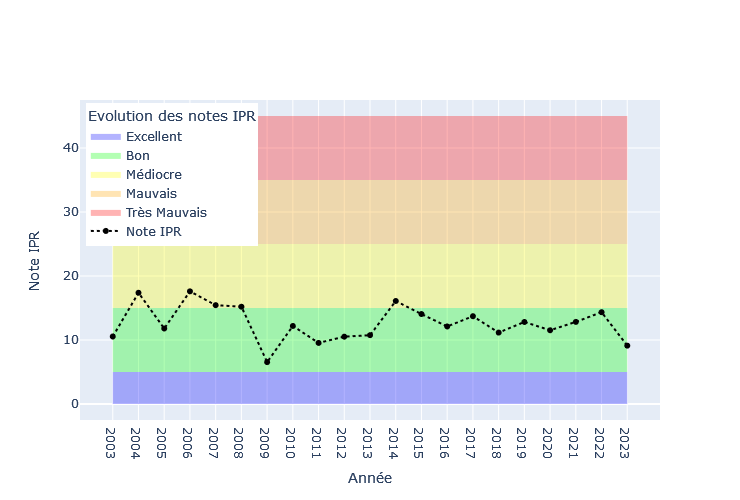

In [276]:
plotly.offline.init_notebook_mode()

discrete_color = {
    'Excellent': 'rgba(0, 0, 255, 0.3)',  # bleu avec opacité  dernier chiffre 0.3
    'Bon': 'rgba(0, 255, 0, 0.3)',         # vert avec opacité
    'Médiocre': 'rgba(255, 255, 0, 0.3)',  #jaune ...
    'Mauvais': 'rgba(255, 165, 0, 0.3)',   # orange ..
    'Très Mauvais': 'rgba(255, 0, 0, 0.3)' # rouge ;...
}

annees = df_all_data_indic['annee']
ipr_notes = df_all_data_indic['ipr_note']

color_ranges = [(0, 5, 'Excellent'), (5, 15, 'Bon'), (15, 25, 'Médiocre'), (25, 35, 'Mauvais'), (35, 45, 'Très Mauvais')]

fig = go.Figure()

for v_min, v_max, label in color_ranges:
    fig.add_trace(go.Scatter(
        x=np.concatenate([annees, annees[::-1]]),
        y=np.concatenate([np.repeat(v_min, len(annees)), np.repeat(v_max, len(annees))]),
        fill='toself',
        fillcolor=discrete_color[label],
        line=dict(color='rgba(255, 255, 255, 0)'),
        hoverinfo='text',
        hovertext=label,
        showlegend=True,
        name=label
    ))

fig.add_trace(go.Scatter(
    x=annees,
    y=ipr_notes,
    mode='lines+markers',
    line=dict(color='black', dash='dot'),
    name='Note IPR'
))

fig.update_layout(xaxis_title='Année', 
                  yaxis_title='Note IPR', 
                  legend=dict(yanchor="top",
                              y=0.99, 
                              xanchor="left", 
                              x=0.01,
                             title="Evolution des notes IPR"))

fig.update_layout(hovermode='x unified')
fig.update_layout(width=800, height=500)

fig.show()

<hr style="border-width: 2px ; border-color: #ADD8E6">

### 2.8- Comparaison IPR - Valeur de la métrique

In [277]:
ipr_valeurs = df_all_data_indic[['ipr_nte',
 'ipr_ner',
 'ipr_nel',
 'ipr_dit',
 'ipr_dii',
 'ipr_dio',
 'ipr_dti',
 'ipr_note','annee']]

In [278]:
df_melted = pd.melt(ipr_valeurs, id_vars=['annee'], value_vars=['ipr_nte',
 'ipr_ner',
 'ipr_nel',
 'ipr_dit',
 'ipr_dii',
 'ipr_dio',
 'ipr_dti'], var_name='metriques', value_name='valeur')

In [279]:
df_melted.annee = df_melted.annee.astype(int)

On représente l'ensemble des valeurs de métriques :

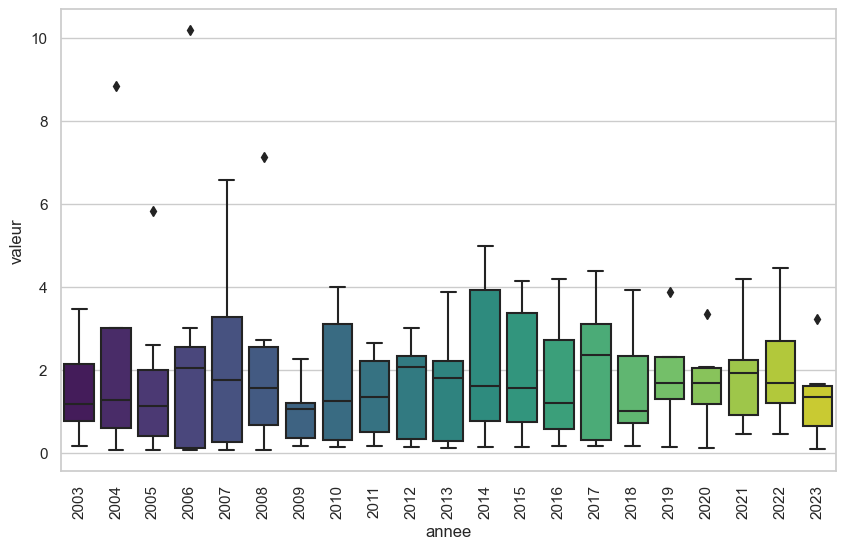

In [280]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_melted, x='annee', y='valeur', palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

On sépare la table en deux groupes d'années : avant et aprés 2010  

In [281]:
df_meltedsup2010 = df_melted.query("annee>=2010")
df_meltedinf2010 = df_melted.query("annee<2010")

On représente les valeurs par métrique pour chaque année d'opération :

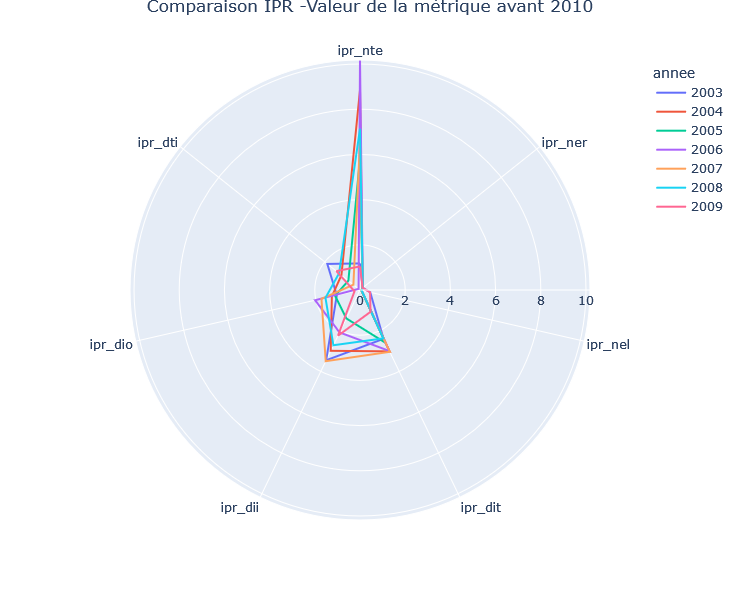

In [282]:
fig = px.line_polar(df_meltedinf2010, r='valeur', theta='metriques', line_close=True,color='annee', line_group='annee')
fig.update_layout(width=800, height=600)
fig.update_layout(
    title_text='Comparaison IPR -Valeur de la métrique avant 2010',
    title_x=0.5,
    title_y=1 )
fig.show()

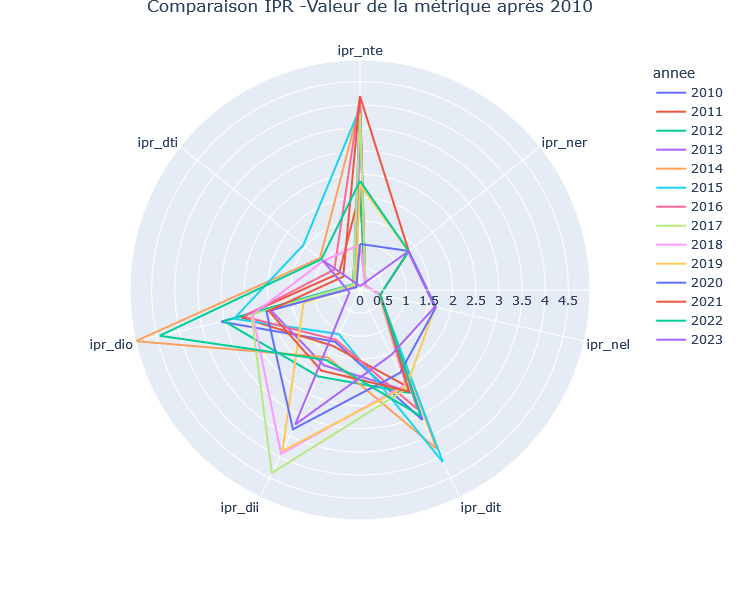

In [283]:
fig = px.line_polar(df_meltedsup2010, r='valeur', theta='metriques', line_close=True,color='annee', line_group='annee')
fig.update_layout(width=800, height=600)
fig.update_layout(
    title_text='Comparaison IPR -Valeur de la métrique après 2010',
    title_x=0.5,
    title_y=1 )
fig.show()

<hr style="border-width: 2px ; border-color: #ADD8E6">

## 2.9- Qualification des opérations sur la station  


A l'aide de la table `df_all_data_indic` précédemment obtenue avec l'interrogation de l'API, on peut regarder l'état d'avancement des opérations par qualification avec une représentation Heatmap.

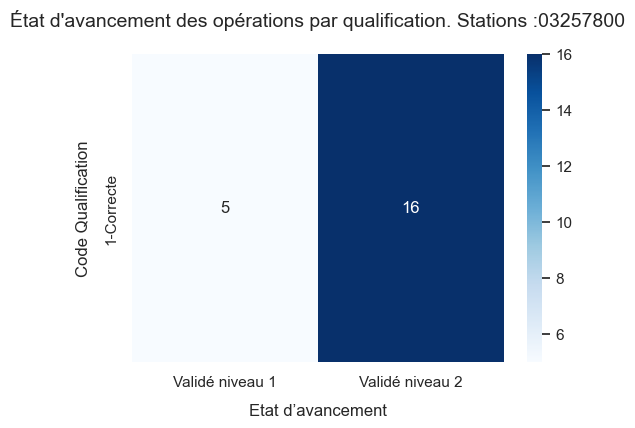

In [284]:
#tableau croisé dynamique
pivot_table = pd.pivot_table(df_all_data_indic, index=['code_qualification_operation', 'libelle_qualification_operation'], 
                             columns='etat_avancement_operation', 
                             aggfunc='size', 
                             fill_value=0)

plt.figure(figsize=(6,4))

#format general et valeurs réelles des annotations sur le heatmap
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Etat d’avancement',labelpad=10)
plt.ylabel('Code Qualification',labelpad=10)
plt.title(f"État d\'avancement des opérations par qualification. Stations :{list(df_all_data_obs.code_station.unique())[0]}", pad=20, fontsize=14)

plt.show()

<hr style="border-width: 2px ; border-color: #ADD8E6">

### 2.10 Description des objectifs associés aux d'operations

On récupère l'ensemble des `code_operation` sur le endpoint `indicateurs`.
Afin d'avoir une vue générale des objectifs des opérations pour l'ensemble de stations entre 2018 et 2022.

On ne garde que certains champs :

Les deux premiers champs font référence à la colonne `date_operation` et permette d'obtenir l'emprise temporelle (min et max) :
- `date_operation_max`
- `date_operation_min`

Ensuite la liste des noms de colonnes (séparés par une virgule) :

- `fields=code_station,objectifs_operation,date_operation`

On réalise la requête de filtre :

In [285]:
requ = 'date_operation_max=2022-01-01&date_operation_min=2018-01-01&fields=code_operation,objectifs_operation,date_operation'

In [286]:
df_all_data_indic_stations = api_lecture.get_all_data(api_lecture.ENDPOINT_INDICATEURS, requ)

Assemblage des pages....
https://hubeau.eaufrance.fr/api/v1/etat_piscicole/indicateurs?date_operation_max=2022-01-01&date_operation_min=2018-01-01&fields=code_operation,objectifs_operation,date_operation&page=1&size=5000
La réponse est partielle et contient 5000 données (le maximum par page) sur  5564. Page chargé n° 1 sur 2 page 
Durée d'exécution : 10.2s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/indicateurs?date_operation_max=2022-01-01&date_operation_min=2018-01-01&fields=code_operation,objectifs_operation,date_operation&page=2&size=5000
La réponse est partielle et contient 5000 données (le maximum par page) sur  5564. Page chargé n° 2 sur 2 page 
Durée d'exécution : 1.82s 

https://hubeau.eaufrance.fr/api/v1/etat_piscicole/indicateurs?date_operation_max=2022-01-01&date_operation_min=2018-01-01&fields=code_operation,objectifs_operation,date_operation&page=3&size=5000
La réponse est complète et contient 5564 données
Durée d'exécution : 0.84s 



In [287]:
df_all_data_indic_stations.head()

code_operation        date_operation  \
0          86867  2021-11-24T09:15:00Z   
1          86851  2021-11-23T09:00:00Z   
2          86836  2021-11-18T15:00:00Z   
3          87301  2021-11-18T09:00:00Z   
4          86840  2021-11-18T08:45:00Z   

                                 objectifs_operation  
0         [RCS – Réseau de Contrôle de Surveillance]  
1         [RCS – Réseau de Contrôle de Surveillance]  
2         [RCS – Réseau de Contrôle de Surveillance]  
3  [RCS – Réseau de Contrôle de Surveillance, RHP...  
4         [RCS – Réseau de Contrôle de Surveillance]

In [288]:
#on récupére l'année sur le champ date_operation
df_all_data_indic_stations = df_all_data_indic_stations.assign(annee=df_all_data_indic_stations['date_operation'].str.slice(0,4))

Les valeurs de la colonne 'objectifs_operation' sont sous forme de liste. 
On récrée un dataframe en ayant une stations , un objetif

In [289]:
#on explose la liste pour garder une valuer d'objectif une stations
df_stations_par_objectif = df_all_data_indic_stations.explode('objectifs_operation').reset_index()

Liste des objectifs contenu dans la table indicateurs

In [290]:
list(df_stations_par_objectif['objectifs_operation'].unique())

['RCS – Réseau de Contrôle de Surveillance',
 'RHP – Réseau Hydrobiologique Piscicole',
 'RCO – Réseau Contrôle opérationnel',
 'Étude',
 'RRP – Réseau de Référence Pérenne',
 'RCA - Réseau de contrôle additionnel',
 "Suivi des populations d'anguilles",
 'Suivi de restauration',
 "RNSORMCE – Réseau National de Suivi des Opérations de Restauration hydroMorphologiques des Cours d'Eau",
 'DCE – Référence',
 "Suivi des cours d'eau intermittents",
 'Suivi des populations de truites',
 'Sauvetage - Transfert']

In [291]:
df_stations_par_objectif.head(2)

index code_operation        date_operation  \
0      0          86867  2021-11-24T09:15:00Z   
1      1          86851  2021-11-23T09:00:00Z   

                        objectifs_operation annee  
0  RCS – Réseau de Contrôle de Surveillance  2021  
1  RCS – Réseau de Contrôle de Surveillance  2021

On filtre le dataframe sur 3 objectifs :

- RCS – Réseau de Contrôle de Surveillance
- RRP – Réseau de Référence Pérenne
- RHP – Réseau Hydrobiologique Piscicole


In [292]:
df_objectif = df_stations_par_objectif.query(
    "objectifs_operation in ('RCS – Réseau de Contrôle de Surveillance','RRP – Réseau de Référence Pérenne','RHP – Réseau Hydrobiologique Piscicole')")

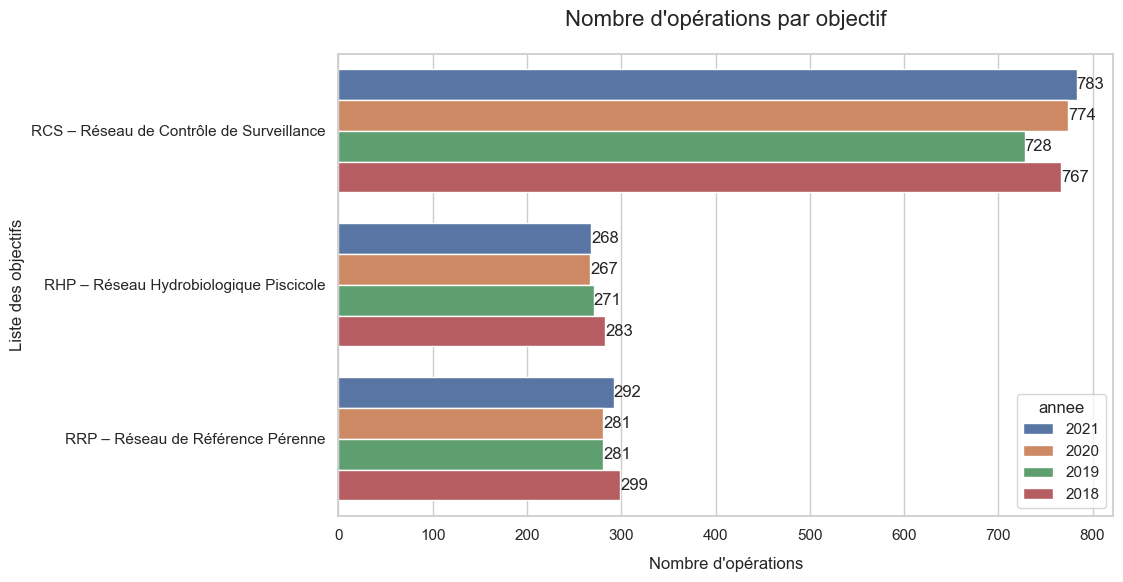

In [293]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df_objectif, y='objectifs_operation', hue='annee', orient='v')
plt.xlabel("Nombre d'opérations",labelpad=10)
plt.ylabel("Liste des objectifs")
plt.title("Nombre d'opérations par objectif", pad=20, fontsize=16)
for row in ax.containers:
    ax.bar_label(row)
plt.show()

In [294]:
def construction_venn(titre, data, stations):
    '''titre::format text pour le titre du graphe
    data :: dataframme avec les colonne stations et année
    stations : str nom de la colonne station'''

    RCS_ = data.query("objectifs_operation == 'RCS – Réseau de Contrôle de Surveillance'")[stations]
    RRP_ = data.query("objectifs_operation == 'RRP – Réseau de Référence Pérenne'")[stations]
    RHP_ = data.query("objectifs_operation == 'RHP – Réseau Hydrobiologique Piscicole'")[stations]

    RCS = set(RCS_)
    RRP = set(RRP_)
    RHP = set(RHP_)

    plt.figure(figsize=(10,10))

    v = venn3([RCS, RRP, RHP], ('RCS','RRP','RHP'), set_colors=('#1ac0c6','#fb7756','#8936b3'))
    c = venn3_circles(subsets=(RCS, RRP, RHP), linestyle='dashed', linewidth=1, color="grey")
    titregraphe = titre + " : Récurrence de la prise de données  sur chaque objectif pour la période : 2018-2020"
    plt.title(titregraphe, pad=20)
    plt.annotate('Nombre d operations présentes \n sur les 3 annéees', xy=v.get_label_by_id('111').get_position()-np.array([0, 0.08]), xytext=(-50,-70)
                 , ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.8', fc='gray', alpha=0.1),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

    plt.show()
    return 

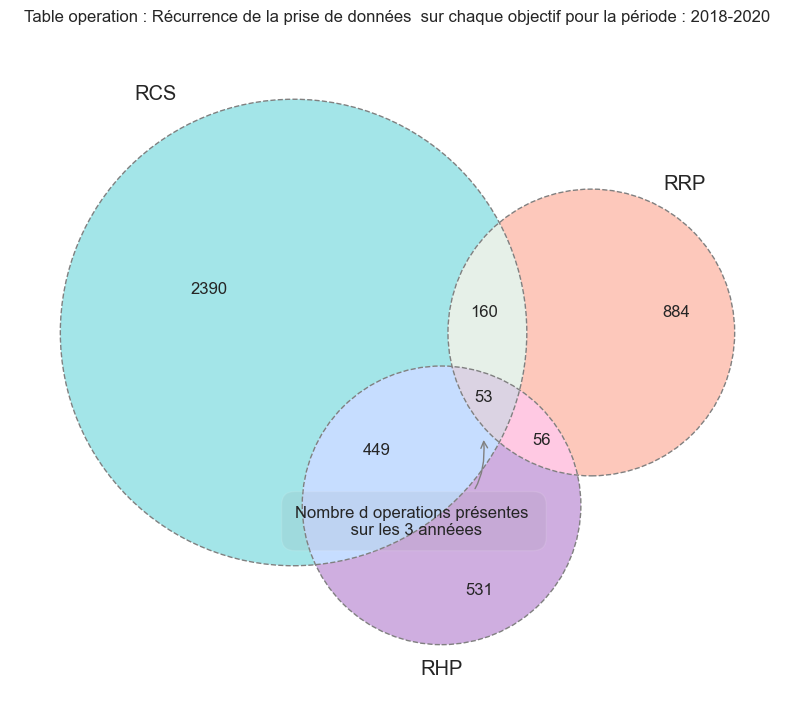

In [295]:
construction_venn("Table operation", df_objectif,'code_operation')

<hr style="border-width: 2px ; border-color: #ADD8E6">

## 3-  Valorisation avec l'API Hub'Eau Hydrobiologie

On peut aussi utiliser l' API Hub'Eau Hydrobiologie pour télécharger les données descriptives de stations référencées par le Sandre. 


In [296]:
print (f'Exemple avec le code stations {df_all_data_obs.libelle_commune.unique()[0]}')

Exemple avec le code stations BRILLEVAST


In [297]:
requ = f'code_station_hydrobio={df_all_data_obs.code_station.unique()[0]}'
df_all_data_hydro = api_lecture.get_all_data(api_lecture.ENPOINT_HYDROLOGIE, requ)

Assemblage des pages....
https://hubeau.eaufrance.fr/api//v1/hydrobio/indices?code_station_hydrobio=03257800&page=1&size=5000
La réponse est complète et contient 282 données
Durée d'exécution : 0.85s 

https://hubeau.eaufrance.fr/api//v1/hydrobio/indices?code_station_hydrobio=03257800&page=2&size=5000
La réponse est complète et contient 282 données
Durée d'exécution : 0.814s 



A l aide de la table `df_all_data_hydro` précédemment obtenue avec l'interrogation de l'API , on peut regarder l'état d'avancement des opérations par qualification avec une représentation Heatmap.

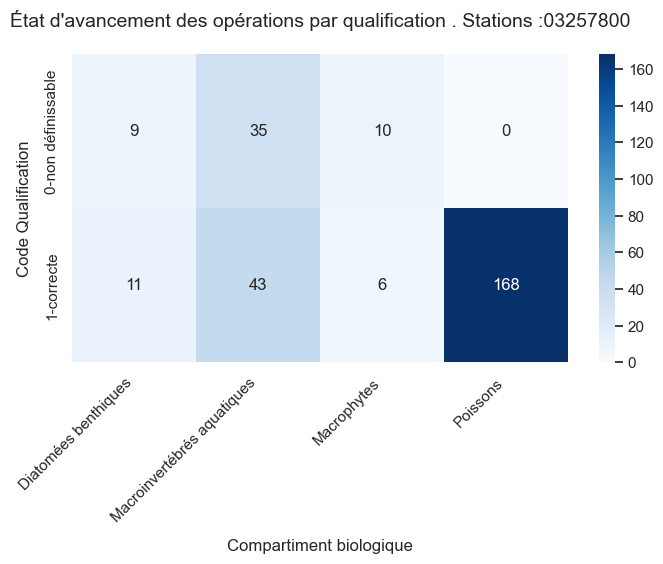

In [298]:
plt.figure(figsize=(8, 4))
#tableau croisé dynamique
pivot_table = pd.pivot_table(df_all_data_hydro, index=['code_qualification', 'libelle_qualification'], columns='libelle_support', aggfunc='size', fill_value=0)

#format general et valeurs réelles des annotations sur le heatmap
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Compartiment biologique',labelpad=10)
plt.ylabel('Code Qualification',labelpad=10)
plt.title(f"État d\'avancement des opérations par qualification . Stations :{list(df_all_data_obs.code_station.unique())[0]}", pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

<hr style="border-width: 2px ; border-color: #ADD8E6">

Lexique

In [299]:
%whos

Variable                      Type             Data/Info
--------------------------------------------------------
APIPoisson                    type             <class '__main__.APIPoisson'>
alt                           module           <module 'altair' from 'C:<...>es\\altair\\__init__.py'>
annees                        Series           0     2003\n1     2004\n2<...>ame: annee, dtype: object
api_lecture                   APIPoisson       <__main__.APIPoisson obje<...>ct at 0x0000027C476ECC10>
api_url                       str              https://hubeau.eaufrance.<...>etat_piscicole/operations
ax                            Axes             Axes(0.125,0.11;0.775x0.77)
axe                           BarContainer     <BarContainer object of 6 artists>
base_url                      str              https://hubeau.eaufrance.fr/api
box_map                       GeoDataFrame          code_station  coordo<...>\n[7180 rows x 5 columns]
color_ranges                  list             n=5
constru